# Overview

Now that we have done EDA and gotten a better sense of the data, it's time to fit the model. Again, our goal is to estimate the annual income that an owner can expect from his listing (in New York). Here is a brief description of the datasets we have:

1. The listings dataset contains information pertaining to a listing, such as average nightly price, location, and number of bedrooms. 
2. The reviews dataset contains the text data for each review written, as well as relevant info pertaining to the review( ex. the date it was written on)
3. The calendar dataset contains information on availability and price for the next 365 days.

Here are some of the high-level findings from the EDA
1. 

# How We Will Model Annual Income

The calendar dataset has information on availability for the next 365 days, so based on this information we know how many days in the next year a given listing will be available. Here is how we plan to predict annual income:

1. Using the listings dataset and the reviews dataset, create a model for the average nightly price of a listing.
2. Using the calendar dataset, find out how many days in the upcoming year the listing will be available for someone to rent.
3. Model occupancy rate by using the "San Francisco Model" used by the San Francisco Planning Department (described in more detail later).
4. Multiply the average price predicted in step 1 by the number of days available (found in step 2) by the occupacy rate (found in step 3) to obtain an estimate for the annual income.


First, we will clean the two datasets with significant missing values (listings and calendar). Then, we will do feature engineering on the reviews dataset, coming up with new features based on the review text as well as generating sentiment scores for each review. After that, we will combine the cleaned reviews and listings modify the features (create dummy variables, remove redundant features, etc) so that it's ready for model fitting. Lastly, we will fit the model for average price and use that to estimate annual income (as described above).

In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.impute import SimpleImputer
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from wordcloud import WordCloud, STOPWORDS
from re import sub
import scipy.stats as stats
from sklearn import preprocessing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


## load in datasets
data_calendar = pd.read_csv('./Data/calendar.csv')
listings_full = pd.read_csv('./Data/listings_full.csv')
reviews_full = pd.read_csv('./Data/reviews_full.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Cleaning

## Calendar

For calendar, we will aggregate the dataset by listing_id. There are some dates with missing price information, but since we only want the availability information from this dataset (we have information on price in the listings dataset), there's no need to drop rows with missing values since there are no missing values for availability. 
The most important column in the aggregated dataset is "annual_availability", which is the number of days available in the next 365 days. We will use this information to estimate annual income.

In [2]:
data_calendar.isnull().sum()

listing_id          0
date                0
available           0
price             364
adjusted_price    364
minimum_nights     14
maximum_nights     14
dtype: int64

In [3]:
# =============================================================================
# aggregate the calendar dataset
# =============================================================================

calendar_summary = (
        data_calendar
        .groupby('listing_id')
        .agg({
            'available': lambda x: np.sum(x == 't'),
            'minimum_nights': np.mean,
            'maximum_nights': np.mean,
        }))

calendar_summary = calendar_summary.reset_index()
calendar_summary.rename(columns = {'available':'annual_availability'}, inplace=True)
calendar_summary.head()

,listing_id,annual_availability,minimum_nights,maximum_nights
0,2595,365,7.000000,1125.0
1,3831,137,1.000000,730.0
2,5099,0,3.000000,21.0
3,5121,365,29.000000,730.0
4,5178,216,1.868493,14.0


## Listings

Here is what we did to clean the listings dataset:

1. Drop columns that have more than 60% missing values.
2. For quantitative columns, impute missing values with the column mean. 
3. For categorical columns, create a new class called "Unknown" for the entries with missing values. This is because we believe a missing value in itself might contain some information and thus should be incorporated as a class of that variable.
4. For text data, create binary columns indicating whether or not a listing has valid text entries in those columns, for we believe the absence of text can carry some information worth modeling.
5. Use problem-specific knowledge to modify features. For example, if a listing is for a private room, then the number of bedrooms should be changed to 1. Other examples include modifying a text column containing all the amenities to a column of just the number of amenities.

In [4]:
# =============================================================================
# Cleaning the listings dataset
# =============================================================================

## drop the columns with over 60% NA
percent_NA = np.sum(listings_full.isnull()) * 100 / len(listings_full)
col_many_na = percent_NA[percent_NA > 60].index
listings_full.drop(col_many_na, axis = 1, inplace = True)

## delete these columns, which contains irrelevant information such as url's and metadata about scraping
## city, state, market doesn't matter since all of our listings are in New York
## for most listings, experiences_offered is "none", which is the same as NA
col_to_del = ['listing_url', 'scrape_id', 'last_scraped', 'experiences_offered',
              'picture_url', 'host_url', 'country_code', 'country', 'calendar_last_scraped',
              'city', 'state', 'market']
listing1 = listings_full.drop(col_to_del, axis = 1)


percent_NA = np.sum(listing1.isnull()) * 100 / len(listing1)
col_w_na = percent_NA[percent_NA > 0].index


## convert numeric variables from strings to floats
def to_num(x):
    x = re.sub(r',', '', x)
    return float(x[1:])

listing1['price'] = listing1['price'].apply(to_num)
valid_ind_security = ~listing1['security_deposit'].isnull()
listing1.loc[valid_ind_security, 'security_deposit'] = (
        listing1.loc[valid_ind_security, 'security_deposit'].apply(to_num))
valid_ind_clean = ~listing1['cleaning_fee'].isnull()
listing1.loc[valid_ind_clean, 'cleaning_fee'] = (
        listing1.loc[valid_ind_clean, 'cleaning_fee'].apply(to_num))
listing1['extra_people'] = listing1['extra_people'].apply(to_num)

listing1['cleaning_fee'] = listing1['cleaning_fee'].astype(float)
listing1['security_deposit'] = listing1['security_deposit'].astype(float)


def str_to_pct(x):
    x = re.sub(r'%', '', x)
    return float(x) / 100
valid_ind_host= ~listing1['host_response_rate'].isnull()

listing1.loc[valid_ind_host, 'host_response_rate'] = (
        listing1.loc[valid_ind_host, 'host_response_rate'].apply(str_to_pct))
listing1['host_response_rate'] = listing1['host_response_rate'].astype(float)


## impute quantitative columns with missing values by the column mean
num_col_w_na = [
        'host_response_rate', 'host_listings_count', 'host_total_listings_count',
        'bathrooms', 'bedrooms', 'beds', 'security_deposit',
        'cleaning_fee', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month']

na_imputer = SimpleImputer(strategy = 'mean')
na_imputer.fit(listing1[num_col_w_na])
listing1[num_col_w_na] = na_imputer.transform(listing1[num_col_w_na])


## replace NA's in categorical columns with a label called "Unknown"
qualtv_col = col_w_na[~col_w_na.isin(num_col_w_na)]
for col_name in qualtv_col:
    na_row_ind = listing1[col_name].isnull()
    listing1.loc[na_row_ind, col_name] = 'Unknown'

## for text columns with NA's, create another binary column indicating whether or not there was content 
col_to_binary = ['name', 'summary', 'space', 'description', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules', 'host_name',
       'host_location', 'host_about', 'host_thumbnail_url',
       'host_picture_url', 'host_verifications', 'zipcode', 'first_review', 
       'last_review']
for col in col_to_binary:
    binary_col_name = 'has_' + col
    listing1[binary_col_name] = ((listing1[col] != 'Unknown') & (listing1[col] != 'None')).astype(int)


## change number of bedrooms to 1 if listing is not entire home/apartment
listing1['bedrooms_new'] = listing1['bedrooms']
listing1.loc[listing1['room_type'] != 'Entire home/apt', 'bedrooms_new'] = 1

## create column for number of years for which the host has been a host
listing1['host_years'] = listing1['host_since'].apply(
        lambda x: 2019 - int(x[0:4]) if x != 'Unknown' else np.nan)
na_imputer1 = SimpleImputer(strategy = 'mean')
na_imputer1.fit(listing1[['host_years']])
listing1['host_years'] = na_imputer1.transform(listing1[['host_years']])

## create columns for number of amenities and number of host verifications
listing1['num_amenities'] = listing1['amenities'].apply(
        lambda x: len(re.sub(r'[{}]', '', x).split(",")) if x != '{}' else 0)
listing1['num_host_verifications'] = listing1['host_verifications'].apply(
        lambda x: len(re.sub(r'[\[\]]', '', x).split(",")) 
        if (x != '[]' and x != 'None') else 0)
    
## compute character counts of some text columns
col_text = ['name', 'summary', 'space', 'description', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'host_about', 'host_verifications']
for col in col_text:
    col_text_length = col + '_length'
    listing1[col_text_length] = listing1[col].apply(
            lambda x: len(x) if x != 'Unknown' else 0)


In [5]:
clean_listings = listing1.copy()
clean_listings.head()

,id,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,...,space_length,description_length,neighborhood_overview_length,notes_length,transit_length,access_length,interaction_length,house_rules_length,host_about_length,host_verifications_length
0,2595,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...","- Spacious (500+ft²), immaculate and nicely fu...","Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,Unknown,Apartment is located on 37th Street between 5t...,"Guests have full access to the kitchen, bathro...",I am a Sound Therapy Practitioner and Kundalin...,...,1000,1000,217,0,502,103,762,107,427,121
1,3831,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Just the right mix of urban center and local n...,Unknown,B52 bus for a 10-minute ride to downtown Brook...,"You will have the private, exclusive use of an...","We'll be around, but since you have the top fl...",...,1000,1000,108,0,1000,596,217,83,46,36
2,5099,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment has a true New Yo...,I have a large 1 bedroom apartment centrally l...,My large 1 bedroom apartment has a true New Yo...,My neighborhood in Midtown East is called Murr...,Read My Full Listing For All Information. New ...,From the apartment is a 10 minute walk to Gran...,I will meet you upon arrival.,I usually check in with guests via text or ema...,...,1000,1000,896,274,1000,29,140,149,77,55
3,5121,BlissArtsSpace!,Unknown,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,Unknown,Unknown,Unknown,Unknown,Unknown,...,1000,1000,0,0,0,0,0,0,373,112
4,5178,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"You will use one large, furnished, private roo...",Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",Reservation should be made at least a few days...,Unknown,Bathroom is shared with the host but the kitch...,Unknown,...,1000,1000,47,229,0,74,0,114,106,41


## Reviews

Sam will describe what we did to clean reviews

In [6]:
## drop observations in the datset with no reviews
reviews_brief_cleaned = reviews_full.dropna(subset=["comments"]).reset_index(drop=True)

def clean(s):
    s = sub(r"[,!?.\/)('‘’“”+-:;–—\r\n\t\xa0]", " ", s)
    return (s.lower())

reviews_brief_cleaned.comments = [clean(row) for row in reviews_brief_cleaned.comments]

## return English comments only
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True
    
is_eng = reviews_brief_cleaned.comments.apply(isEnglish)
reviews_full = reviews_brief_cleaned[is_eng].reset_index(drop = True)
reviews_full.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2595,19176,2009-12-05,53267,Cate,great experience
1,2595,19760,2009-12-10,38960,Anita,i ve stayed with my friend at the midtown cast...
2,2595,34320,2010-04-09,71130,Kai-Uwe,we ve been staying here for about nights en...
3,2595,46312,2010-05-25,117113,Alicia,we had a wonderful stay at jennifer s charming...
4,2595,1238204,2012-05-07,1783688,Sergey,hi to everyone would say our greatest compli...


# Feature Engineering

At the previous data cleaning stage, we generate or modify the following features:
1. The number of bedrooms is set to 1 if the room type is private or shared.
2. The starting date of being a host, a date variable, is converted to the length of being a host. This feature might reflect the experience and sustainability of a listing owner, a potentially revelant factor to the listing price.
3. "Amenities" and "host_verifications" column, both text columns, are engineered into quantitative columns, namely, the number of amenities at the listing and the number of different verification means passed by the host.
4. We compute the character counts of several text columns as a proxy to how detailed the descriptions are


* Sentiment scores - SAM

In [7]:
## drop observations in the datset with no reviews
reviews_full = reviews_full.dropna(subset=["comments"]).copy()

In [8]:
## count the length of a review in terms of number of words
def count_words(string):
    return len(string.split())

reviews_full["nwords"] = reviews_full["comments"].apply(count_words)

In [9]:
## returns the proportion of punctuation marks in the comment
def prop_punc(input_str):
    return len(re.findall(f"[{string.punctuation}]", input_str))/len(input_str)

reviews_full["punc_prop"] = reviews_full["comments"].apply(prop_punc)

In [10]:
## returns whether or not there were more than 2 consecutive exclamation marks in the comment
def excl(input_str):
    return int(len(re.findall("!!(.*)", input_str))>0)

reviews_full[">2_exclamation"] = reviews_full["comments"].apply(excl)

In [11]:
## returns the proportion of capitalized letters in the comment

upper = re.compile('[A-Z]')

def prop_cap(input_str):
    return len(upper.findall(input_str))/len(input_str)

reviews_full["prop_cap"] = reviews_full["comments"].apply(prop_cap)

#### Sentiment Scores
For now, I will generate a column of all 1's. Replace with Sam's code when done

In [12]:
# Pull sentiment scores 
analyzer = SentimentIntensityAnalyzer()
reviews_full["sentiments"] = reviews_full.comments.apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [13]:
reviews_full.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,nwords,punc_prop,>2_exclamation,prop_cap,sentiments
0,2595,19176,2009-12-05,53267,Cate,great experience,2,0.0,0,0.0,0.6249
1,2595,19760,2009-12-10,38960,Anita,i ve stayed with my friend at the midtown cast...,92,0.0,0,0.0,0.9274
2,2595,34320,2010-04-09,71130,Kai-Uwe,we ve been staying here for about nights en...,64,0.0,0,0.0,0.9136
3,2595,46312,2010-05-25,117113,Alicia,we had a wonderful stay at jennifer s charming...,25,0.0,0,0.0,0.9409
4,2595,1238204,2012-05-07,1783688,Sergey,hi to everyone would say our greatest compli...,97,0.0,0,0.0,0.9863


In [14]:
## get a data frame containing mean feature values for each listing
reviews_summary = (
        reviews_full
        .groupby('listing_id')
        .agg({
            'nwords': np.mean,
            'punc_prop': np.mean,
            '>2_exclamation': np.mean,
            'prop_cap': np.mean,
            'sentiments': np.mean
        }))

## combine the reviews and listings datasets
data = pd.merge(clean_listings, reviews_summary, 'inner', left_on = 'id', right_on = 'listing_id')
data.head()

,id,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,...,access_length,interaction_length,house_rules_length,host_about_length,host_verifications_length,nwords,punc_prop,>2_exclamation,prop_cap,sentiments
0,2595,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...","- Spacious (500+ft²), immaculate and nicely fu...","Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,Unknown,Apartment is located on 37th Street between 5t...,"Guests have full access to the kitchen, bathro...",I am a Sound Therapy Practitioner and Kundalin...,...,103,762,107,427,121,59.333333,0.000312,0,0.0,0.797502
1,3831,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Just the right mix of urban center and local n...,Unknown,B52 bus for a 10-minute ride to downtown Brook...,"You will have the private, exclusive use of an...","We'll be around, but since you have the top fl...",...,596,217,83,46,36,46.769231,0.000152,0,0.0,0.816304
2,5099,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment has a true New Yo...,I have a large 1 bedroom apartment centrally l...,My large 1 bedroom apartment has a true New Yo...,My neighborhood in Midtown East is called Murr...,Read My Full Listing For All Information. New ...,From the apartment is a 10 minute walk to Gran...,I will meet you upon arrival.,I usually check in with guests via text or ema...,...,29,140,149,77,55,71.142857,0.000508,0,0.0,0.780059
3,5121,BlissArtsSpace!,Unknown,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,Unknown,Unknown,Unknown,Unknown,Unknown,...,0,0,0,373,112,54.354167,0.000212,0,0.0,0.861077
4,5178,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"You will use one large, furnished, private roo...",Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",Reservation should be made at least a few days...,Unknown,Bathroom is shared with the host but the kitch...,Unknown,...,74,0,114,106,41,63.256000,0.000227,0,0.0,0.734395


# Feature Modification

Now that we have a dataset with all the features from the listings, reviews, and calendar dataset, along with some features that we created, let's prepare our dataset for model fitting. Here is what we will do:

1. Remove features that don't intuitively impact price or occupancy (ex. listing id, host_name).
2. Remove redundant features: for example, "street", "neighbourhood", "neighborhood_cleansed" all have values like "Brooklyn", so I will only keep "neighborhood_cleansed" and delete the other two features
3. Encode binary categorical features as 0 or 1
4. Create dummy variables for categorical features with multiple classes. For categorical features with high cardinality, we will use likelihood encoding, which essentially encodes each class of a categorical feature with the mean target value within that class, given some regularization. This will allow us to create labels that are directly correlated with the target while avoiding creating too many dummy variables and making our dataset too sparse.

In [16]:
## Convert host_response_rate to quantititave
data['host_response_rate'] = data["host_response_rate"].astype(float)

## Convert host_acceptance_rate to quantititave
accept_rate = data['host_acceptance_rate'].copy()
accept_rate[accept_rate == "Unknown"] = '-100'
accept_rate = accept_rate.apply(str_to_pct)
accept_rate[accept_rate == -1] = accept_rate[accept_rate != -1].mean() # replace all "unknown" with the average
data['host_acceptance_rate'] = accept_rate

In [17]:
## drop all irrelevant/redundant/text features
data = data.iloc[:, 15:]

data.drop(['host_thumbnail_url', 'host_about', 'host_neighbourhood', 'host_picture_url', 'host_verifications', 'street', 'neighbourhood',
          'zipcode', 'smart_location', 'amenities', 'calendar_updated', 'has_availability', 'availability_30',
          'availability_60', 'availability_90', 'first_review', 'last_review', ], axis=1, inplace=True)

In [18]:
## convert all binary categorical features to 0 or 1

data["host_is_superhost"] = np.where(data["host_is_superhost"] == "t", 1, 0)
data["host_has_profile_pic"] = np.where(data["host_has_profile_pic"] == "t", 1, 0)
data["host_identity_verified"] = np.where(data["host_identity_verified"] == "t", 1, 0)
data["is_location_exact"] = np.where(data["is_location_exact"] == "t", 1, 0)
data["requires_license"] = np.where(data["requires_license"] == "t", 1, 0)
data["instant_bookable"] = np.where(data["instant_bookable"] == "t", 1, 0)
data["is_business_travel_ready"] = np.where(data["is_business_travel_ready"] == "t", 1, 0)
data["require_guest_profile_picture"] = np.where(data["require_guest_profile_picture"] == "t", 1, 0)
data["require_guest_phone_verification"] = np.where(data["require_guest_phone_verification"] == "t", 1, 0)

In [19]:
## split dataset into quantitative variables (binary, nonbinary) and categorical variables

categorical_vars = data.loc[:, data.dtypes == object]
float_vars = data.loc[:, data.dtypes == 'float64']
int_vars = data.loc[:, data.dtypes == 'int64']
quantitative_vars = pd.concat([float_vars, int_vars], axis=1)

## extract the response variables for price and occupancy
price = quantitative_vars["price"].copy()
quantitative_vars.drop(['price'], axis = 1, inplace = True)

## split quantitative variables into binary and nonbinary
binary = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 
          'requires_license', 'instant_bookable', 'is_business_travel_ready', 'require_guest_profile_picture',
          'require_guest_phone_verification', 'has_summary', 'has_space', 'has_description',
          'has_neighborhood_overview', 'has_notes', 'has_transit', 'has_access', 'has_interaction', 
          'has_house_rules', 'has_host_name', 'has_host_location', 'has_host_about', 'has_host_thumbnail_url',
          'has_host_picture_url', 'has_host_verifications', 'has_zipcode', 'has_first_review', 'has_last_review']

nonbinary_quant = [x for x in quantitative_vars.columns if x not in binary]

binary_vars = quantitative_vars.loc[:, binary]
nonbinary_quant_vars = quantitative_vars.loc[:, nonbinary_quant]

## normalize quantative features
nonbinary_vars_normalized = nonbinary_quant_vars.apply(lambda x: preprocessing.scale(x), axis = 0)

In [20]:
## use likelihood encoding for neighbourhood_cleansed, which has 219 unique values
ce_target = ce.TargetEncoder(cols = ['neighbourhood_cleansed'])
ce_target.fit(categorical_vars, price)
categorical_vars = ce_target.transform(categorical_vars, price)

In [21]:
## create dummy variables for categorical features
def dummy_df(df, feature_names):
    dummydf = pd.DataFrame()
    for name in feature_names:
        tmp = pd.get_dummies(df.loc[:,name], prefix= name, prefix_sep='_')
        dummydf = pd.concat([dummydf, tmp], axis = 1)
    return dummydf

## we won't create dummy variables for neighbourhood, since there are 219 unique values
## the neighbourhood_group variable also captures location information, with only 5 unique values
categorical_features = [x for x in categorical_vars.columns]
dummy_vars = dummy_df(categorical_vars, categorical_features)
model_data = pd.concat([nonbinary_vars_normalized, binary_vars, dummy_vars], axis = 1)

In [22]:
model_data.head()

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,bathrooms,bedrooms,beds,security_deposit,...,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
0,-3.366526,-2.153667,-0.038457,-0.038457,0.457204,-0.709171,-0.335683,-1.575896,-0.487569,0.237199,...,0,0,0,1,0,0,0,1,0,0
1,0.448289,0.584626,-0.109572,-0.109572,-0.773778,-0.211917,-0.335683,-0.242672,2.108846,0.615132,...,0,0,0,1,0,1,0,0,0,0
2,-0.042811,-0.595673,-0.109572,-0.109572,0.350248,-0.527542,-0.335683,-0.242672,-0.487569,0.111221,...,0,0,0,1,0,1,0,0,0,0
3,-0.042811,-0.784521,-0.109572,-0.109572,-0.742500,-0.133218,0.022871,-0.242672,-0.487569,0.489154,...,0,1,0,0,0,0,0,1,0,0
4,-0.314674,0.773474,-0.109572,-0.109572,0.659791,-0.733195,-0.335683,-0.242672,-0.487569,0.034949,...,0,0,0,1,0,0,0,1,0,0


# Model Fitting

## Who Will Our Model Work For?

In order to make an accurate model, we will remove the outliers for our target variable, price. Since a vast majority of the listings in the dataset are under 400 dollars, we will remove all observations over 400 dollars. This means that our model will not work well for predicting price for very expensive listings, which we will accept because these listings account for 3% of our data. Furthermore, our final goal is to predict annual income, and we imagine occupancy becomes very unstable and hard to model for a listing that's particularly expensive. 


Text(0.5, 1.0, 'Distribution of Prices Under $1000 in Dataset')

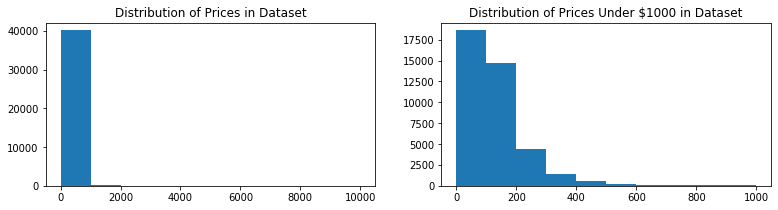

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(13, 3))
axs[0].hist(price)
axs[0].set_title("Distribution of Prices in Dataset")
axs[1].hist(price[price<1000])
axs[1].set_title("Distribution of Prices Under $1000 in Dataset")

In [24]:
print("The proportion of listings over $400:", sum(price > 400)/len(price))

The proportion of listings over $400: 0.029189296431317114


In [25]:
Y = price[price<400]
X = model_data.loc[price<400,:]

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=100)
#dummies_train, dummies_test, price_train, price_test = train_test_split(model_data_encoded, price, test_size=0.2, random_state=10)

## a function to compute the rmse
def compute_rmse(predictions, yvalues):
    return np.sqrt(sum((np.array(predictions)-np.array(yvalues))**2)/len(yvalues))

## Linear Regression

In [27]:
mod = sm.OLS(Y_train, X_train)
fitted_model = mod.fit()

test_pred = fitted_model.predict(X_test)
compute_rmse(test_pred, Y_test)

43.33225928057462

#### Assumptions
Here are the assumptions that we will check:

1. The relationship between the covariates and the response variable can be modelled linearly.
2. The expectation of errors is 0
3. the errors have equal variance (homoskedastic)

[Text(0, 0.5, 'Residuals'), Text(0.5, 0, 'Predicted')]

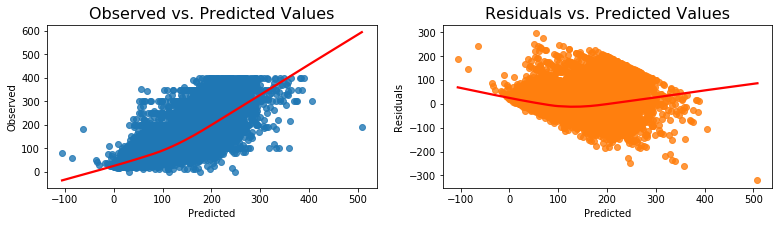

In [32]:
## check for linearity 
fitted_vals = fitted_model.predict()
resids = fitted_model.resid

fig, ax = plt.subplots(1,2, figsize=(13, 3))
    
sns.regplot(x=fitted_vals, y=Y_train, lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
ax[0].set(xlabel='Predicted', ylabel='Observed')

sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
ax[1].set(xlabel='Predicted', ylabel='Residuals')

Ideally, the points are symmetrically distributed around the line in both plots, which appear to be true.

In [30]:
## confirm the expectation of errors (residuals) is 0
fitted_model.resid.mean()

8.733052178008002e-14

AttributeError: module 'statsmodels.api' has no attribute 'het_breuschpagan'

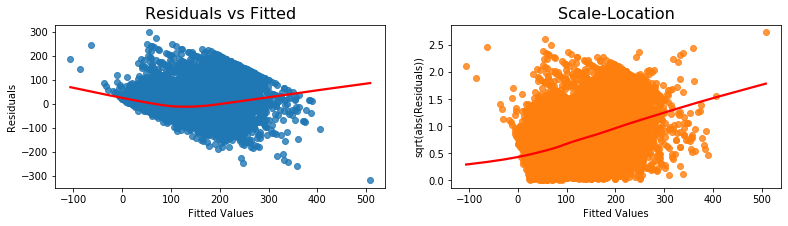

In [37]:
## check for homoscedasticity
resids_standardized = fitted_model.get_influence().resid_studentized_internal

fig, ax = plt.subplots(1,2, figsize=(13, 3))

sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Residuals vs Fitted', fontsize=16)
ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Scale-Location', fontsize=16)
ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')
# The desired outcome should be that the placement of the points 
# should be random and no pattern (increase/decrease in values of residuals) should be visible.

Here, the points are roughly evenly distributed about the line in both plots, so we assume that the errors are homoskedastic.

## Lasso Regression

In [40]:
lasso = Lasso(max_iter=1e4)
parameters = {'alpha': np.arange(.05, 1, .05)}

In [394]:
np.random.seed(seed=1000)
lasso_gridcv = GridSearchCV(lasso, parameters, scoring = 'neg_mean_squared_error', cv = 5)
lasso_gridcv.fit(dummies_train, price_train)
print(lasso_gridcv.best_params_)
print(lasso_gridcv.best_score_)

{'alpha': 0.05}
-82423.50192259565


In [41]:
## fit the model now with the optimal tuning parameter
lassoreg = Lasso(alpha=.05, max_iter=1e5)
lassoreg.fit(X_train, Y_train)

Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=100000.0,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [42]:
lasso_preds = lassoreg.predict(X_test)
compute_rmse(lasso_preds, Y_test)

43.91979518448925

#### Assumptions
Since Lasso regression is in the family of linear models, it has the same assumptions as OLS (listed above). 

[Text(0, 0.5, 'Residuals'), Text(0.5, 0, 'Predicted')]

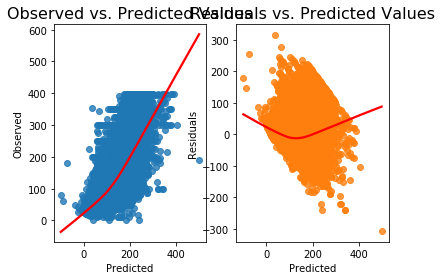

In [45]:
## check linearity 
fitted_vals = lassoreg.predict(X_train)
resids = Y_train - fitted_vals

fig, ax = plt.subplots(1,2, figsize=(13, 3))
    
sns.regplot(x=fitted_vals, y=Y_train, lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
ax[0].set(xlabel='Predicted', ylabel='Observed')

sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
ax[1].set(xlabel='Predicted', ylabel='Residuals')

Ideally, the points are symmetrically distributed around the line in both plots, which appear to be true.

In [46]:
## check the expectation of errors (residuals) is 0
np.mean(resids)

9.36442301514321e-15

Text(0, 0.5, 'Residuals')

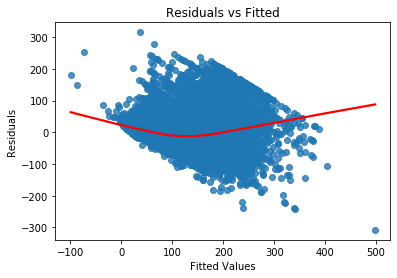

In [56]:
## check for homoscedasticity
## to do this, we look at a plot of residuals (or standardized residuals) vs. predicted (fitted) values.

sns.regplot(x=fitted_vals, y=resids, lowess=True, line_kws={'color': 'red'})
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

Ideally, the points should be randomly spread out and there shouldn't be any visible pattern, both of which appear to be true.

## Random Forest

For the random forest model, I will optimize for the hypermarater "n_estimators", which is the number of trees in the forest. I will use the default values for other hyperparameters such as max_depth and min_samples_leaf as running a grid search across the parameter space for 3 hyperparameters is computationally expensive. 

In [397]:
## initialize the model and parameter space

rf_model = RandomForestRegressor(random_state = 5, max_features = 'sqrt')
parameters = {'n_estimators': np.arange(30, 301, 30)}

np.random.seed(seed=1000)
rf_gridcv = GridSearchCV(estimator = rf_model, param_grid = parameters, cv = 5)
rf_gridcv.fit(X_train, Y_train)
print(rf_gridcv.best_params_)


{'n_estimators': 300}


In [390]:
mod = RandomForestRegressor(n_estimators = 300)
mod.fit(X_train, Y_train)
rf_preds = mod.predict(X_test)
compute_rmse(rf_preds, Y_test)

40.72617598198234

## GBM

For the gradient boosting machine, I will optimize for 2 hyperparameters: learning rate and number of trees. Here, I will use a random search across the parameter space as gradient boosting is computationally expensive across such a large grid of hyperparameters.

In [ ]:
## create the random grid
rates = [.01, .1, .25, .5, .75, 1]
ntrees = [x for x in np.arange(100, 501, 100)]

gb_model = GradientBoostingRegressor(random_state = 5)
parameters = {'learning_rate': rates,
              'n_estimators': ntrees}


gbm_gridcv = GridSearchCV(estimator = gb_model, param_grid = parameters, cv = 5)

gbm_gridcv.fit(X_train, Y_train)

gbm_gridcv.best_params_

In [392]:
gb_model = GradientBoostingRegressor(learning_rate = .1, n_estimators = 500)
gb_model.fit(X_train, Y_train)
gbm_preds = gb_model.predict(X_test)
compute_rmse(gbm_preds, Y_test)

39.750103270932165

## Summary

Overall, the best performing model for price is the GBM with a learning rate of .1 and 500 trees, which yielded a test RMSE of 39. Therefore, we will proceed using this model to predict price.

# Predicting Income

Now that we have a good model for predicting average nightly price, we just need the number of days that the listing will be occupied to get an estimate of the annual income. Here is how we will model annual income:

$${income} =  {price}_{nightly} \times {days}_{Available}\times {Occupancy Rate}$$

### Availability

To get the number of days that a listing is available for rent, we will use the calendar dataset from earlier, where we computed annual availability.

In [396]:
availability = calendar_summary['annual_availability']

### Occupancy Rate

To model occupancy, we will use the "San Francisco Model" as described by the San Francisco Planning Department in [The Executive Summary of Amendments Relating to Short-Term Rentals](https://commissions.sfplanning.org/cpcpackets/2014-001033PCA.pdf). One way that occupancy over a period of time was estimated in the report was by finding the number of reviews over a period of time, multiplying by the average length of stay, and then dividing by the percent of guests that leave reviews (i.e. review rate, which is estimated). For example, if a listing got 20 reviews/year on average, and the average length of stay was 3 days, and we estimate that 50\% of guests who stay in a listing leave reviews, then we have:
$$occupancy = min(20 \times 3 \div .5, 365)$$

Airbnb stated in 2012 that only 72% of guests leave reviews, but we feel this is an overly enthusiastic estimate with little evidence to support the claim. According to [InsideAirbnb.com](http://insideairbnb.com/about.html), "using a review rate of 30.5% is more fact based", so we will return a conservative estimate of annual income by assuming onlt 30.5% of guests leave reviews. To get the occupancy rate over a year, we will divide the days of occupancy by 365.
$${Occupancy Rate} = \frac{min(\overline{reviews}_{annual} \times \overline{length}_{stay} \div .305, 365)}{365}$$